# Check-worthiness detection using Large Language Models

First, the necessary python modules are imported

In [1]:
%load_ext autoreload

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from claimbuster_utils import load_claimbuster_dataset
from tqdm.auto import tqdm
import json
import numpy as np
import re
import torch
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

/cluster/home/matssbra/.conda/envs/fakeNews/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-27 08:31:06.512481: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 08:31:10.836590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 08:31:10.848746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02

## Load model and dataset

In [2]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    torch_dtype=torch.float16,
    quantization_config = bnb_config,
    # attn_implementation="flash_attention_2", 
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
pipe = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer, 
    return_full_text=False,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id
)

data = load_claimbuster_dataset("../data/ClaimBuster_Datasets/datasets")

Loading checkpoint shards: 100%|██████████| 3/3 [01:01<00:00, 20.39s/it]


## Zero-shot classification

In [4]:
with open("../prompts/ClaimBuster/standard/zero-shot.txt", "r") as f:
    instruction = f.read()

texts = data["Text"]
prompts = [f"{instruction} '''{text}'''" for text in texts]
zeroshot_output = "../results/ClaimBuster/zeroshot1.csv"

class ProgressDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __getitem__(self, idx):
        return self.dataset[idx]
    def __len__(self):
        return len(self.dataset)
    
prompts_data = ProgressDataset(prompts)

dataset_with_scores = data.copy()

display(data.head())
dict_matcher = re.compile(r"{.*}")
score_matcher = re.compile(r"([Ss]core[^\d]*)(\d+)")
non_check_worthy_matcher = re.compile(r"(non-checkworthy)|(not check-worthy)|(non check-worthy)")

responses = pipe(prompts_data, batch_size=256)
for index, result in enumerate(tqdm(responses, total=len(prompts))):
    response = result[0]["generated_text"].replace('\n', "")
    dataset_index = data.index[index]
    try:
        parsed_json = json.loads(dict_matcher.search(response).group(0))
        dataset_with_scores.loc[dataset_index, "score"] = parsed_json["score"]
        dataset_with_scores.loc[dataset_index, "reasoning"] = parsed_json["reasoning"]
    except (json.decoder.JSONDecodeError, AttributeError) as e:
        # Try to find score
        score = score_matcher.search(response)
        if score is not None:
            score = score[2]
        else:
            score = 0.0 if non_check_worthy_matcher.search(response) else np.nan
        dataset_with_scores.loc[dataset_index, "score"] = score
        dataset_with_scores.loc[dataset_index, "reasoning"] = response
        continue
dataset_with_scores.to_csv(zeroshot_output, index=True)

,Verdict,Text
sentence_id,,
27247,1,We're 9 million jobs short of that.
10766,1,"You know, last year up to this time, we've los..."
3327,1,And in November of 1975 I was the first presid...
19700,1,And what we've done during the Bush administra...
12600,1,Do you know we don't have a single program spo...


  0%|          | 1/9674 [01:17<208:57:53, 77.77s/it]/tmp/ipykernel_2057738/3099157044.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset_with_scores.loc[dataset_index, "score"] = score[2] if score else np.nan
100%|██████████| 9674/9674 [45:06<00:00,  3.57it/s]  


## Discussion of results

             Verdict                                               Text  \
sentence_id                                                               
25315              1  Georgie Anne, we, believe me, supported the Si...   
33747              1           I have fought against that as a senator.   
15380              1  Six predecessors of mine who served in the Ova...   
5730               1  Even FOX News disputes it, and that doesn't ha...   
33361              1  He choked and then got into a Twitter war beca...   
...              ...                                                ...   
8204               0  But let's not put it there; let's put it in te...   
32104              0                        Oh, you didn't delete them?   
25400              0  We have more at stake in space satellites than...   
33659              0  Well, let me translate that, if I can, Chris, ...   
19323              0  Now, if these aren't special interests, I've g...   

             score      

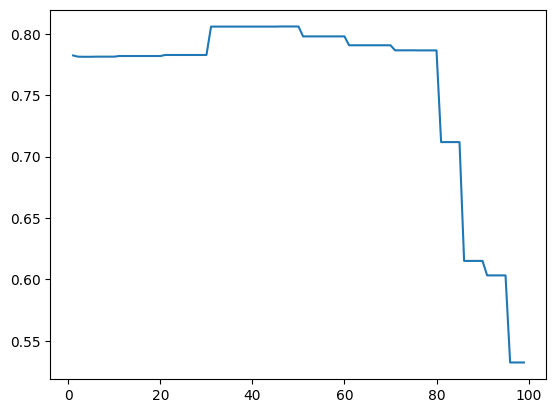

In [10]:
# Print the number of empty scores
dataset_with_scores = pd.read_csv("../results/ClaimBuster/zeroshot1.csv", index_col=0)
print(dataset_with_scores[dataset_with_scores["score"].isna()])
y_gold = dataset_with_scores["Verdict"].values
reports = []
for threshold in range(1, 100):
    y_pred = dataset_with_scores["score"].map(lambda x: 1 if x >= threshold else 0).values
    reports.append(classification_report(y_gold, y_pred, output_dict=True))
# Print highest f1-score
print(max(reports, key=lambda report: report["macro avg"]["f1-score"]))
print(max([report["weighted avg"]["f1-score"] for report in reports]))
plt.plot(range(1, 100), [report["macro avg"]["f1-score"] for report in reports])